# Label transfer + DE analysis comparison

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

import milopy
import milopy.core as milo

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [7]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_DE_comparison/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [8]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');

In [9]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR scArches':pal[7], 'AR':pal[9], 'CR scVI':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [10]:
%%R -i design_palette_df
design_palette <- setNames(design_palette_df$color, rownames(design_palette_df))

scale_color_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

scale_fill_design <- function(){
    scale_color_manual(values=design_palette, name='design')
}

In [11]:
%%R -i figdir
library(tidyverse)
library(patchwork)
library(ggrastr)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [12]:
# figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/atlas_subsampling/'
# if not os.path.exists(figdir):
#     os.mkdir(figdir)

In [13]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [14]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6], 'closest_ACR':pal[2], 'random_ACR':pal[8]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [15]:
# %%R -i figdir -i design_palette_df
# design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

In [16]:

short_pop_names = {
    "DC":'conventional_dendritic_cell', 
    "naive B":'naive_B_cell',
    "memory B":'memory_B_cell',
    "CM CD4+T":'central_memory_CD4_positive_alpha_beta_T_cell', 
    'plasmablast':'plasmablast',
    'platelet':'platelet', 
 "pDC":'plasmacytoid_dendritic_cell',
     "neutrophil":'neutrophil',
    "cDC":'conventional_dendritic_cell',
 'naive CD4+T':'naive_thymus_derived_CD4_positive_alpha_beta_T_cell',
"classical monocyte":'classical_monocyte', 
 'erythrocyte':'erythrocyte',
       "naive CD8+T":'naive_thymus_derived_CD8_positive_alpha_beta_T_cell',
       "NK":'natural_killer_cell',
       "EM CD8+T":'effector_memory_CD8_positive_alpha_beta_T_cell',
       'MAIT':'mucosal_invariant_T_cell', 
 'CD14lo CD16hi monocyte':'CD14_low_CD16_positive_monocyte'}

short_pop_names={v:k for k,v in short_pop_names.items()}

In [17]:
short_pop_names

{'conventional_dendritic_cell': 'cDC',
 'naive_B_cell': 'naive B',
 'memory_B_cell': 'memory B',
 'central_memory_CD4_positive_alpha_beta_T_cell': 'CM CD4+T',
 'plasmablast': 'plasmablast',
 'platelet': 'platelet',
 'plasmacytoid_dendritic_cell': 'pDC',
 'neutrophil': 'neutrophil',
 'naive_thymus_derived_CD4_positive_alpha_beta_T_cell': 'naive CD4+T',
 'classical_monocyte': 'classical monocyte',
 'erythrocyte': 'erythrocyte',
 'naive_thymus_derived_CD8_positive_alpha_beta_T_cell': 'naive CD8+T',
 'natural_killer_cell': 'NK',
 'effector_memory_CD8_positive_alpha_beta_T_cell': 'EM CD8+T',
 'mucosal_invariant_T_cell': 'MAIT',
 'CD14_low_CD16_positive_monocyte': 'CD14lo CD16hi monocyte'}

## Run comparison

See `pseudobulk_for_DE.py` and `run_DE_comparison.py`

## Parse results

In [34]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
dirs = [x for x in os.listdir(outdir) if x.startswith('qPBMC_500cells_demo_perturb_cell_type') and x.endswith('_seed2022')]

res_df_all = pd.DataFrame()
for d in dirs:
    acr_results = pd.read_csv(outdir + d + '/DE_comparison_results.ACR_scArches.csv')
    try:
        ar_results = pd.read_csv(outdir + d + '/DE_comparison_results.AR_scArches.csv')
    except:
        pass
    cr_scvi_results = pd.read_csv(outdir + d + '/DE_comparison_results.CR_scVI.csv')
    cr_scvi_results['design'] = cr_scvi_results['design'] + ' scVI'
    cr_scarches_results = pd.read_csv(outdir + d + '/DE_comparison_results.CR_scArches.csv')
    cr_scarches_results['design'] = cr_scarches_results['design'] + ' scArches'
    res_df = pd.concat([acr_results, ar_results, cr_scvi_results, cr_scarches_results])
    res_df_all = pd.concat([res_df_all, res_df])

In [35]:
res_df_all['perturb_pop_pl'] = [short_pop_names[x] for x in res_df_all['OOR_state_simulation']]

In [36]:
%%R -i res_df_all
head(res_df_all)

                              DE_cell_annotation OOR_state affected_anno
1                CD14_low_CD16_positive_monocyte         0         FALSE
2  central_memory_CD4_positive_alpha_beta_T_cell         2         FALSE
3                             classical_monocyte         0         FALSE
4                    conventional_dendritic_cell         3         FALSE
5 effector_memory_CD8_positive_alpha_beta_T_cell         0         FALSE
6                                    erythrocyte         0         FALSE
          FPR TPR design OOR_state_simulation perturb_pop_pl
1 0.000000000 NaN    ACR        memory_B_cell       memory B
2 0.000000000 NaN    ACR        memory_B_cell       memory B
3 0.000000000 NaN    ACR        memory_B_cell       memory B
4 0.000262605 NaN    ACR        memory_B_cell       memory B
5 0.000000000 NaN    ACR        memory_B_cell       memory B
6         NaN NaN    ACR        memory_B_cell       memory B


In [37]:
%%R -w 1000 -h 700 -o pl_df
pl_df <-res_df_all %>%
    filter(affected_anno) %>%
    mutate(TPR=ifelse(is.na(TPR), 0, TPR)) %>%
    group_by(OOR_state_simulation, design) %>%
    mutate(frac_OOR_state = OOR_state/sum(OOR_state)) %>%
    slice_max(TPR, with_ties=FALSE) %>%
    ungroup() %>%
    group_by(OOR_state_simulation) %>%
    mutate(mean_tpr= median(TPR)) %>%
    ungroup() %>%
    arrange(mean_tpr) %>%
    mutate(perturb_pop_pl = factor(perturb_pop_pl, levels=unique(perturb_pop_pl))) %>%
    mutate(design=factor(design, levels=c('AR', 'CR scArches', 'CR scVI','ACR'))) 

pl2 <- pl_df %>%
    ggplot(aes(perturb_pop_pl, TPR, color=design)) +
    # geom_line(aes(group=design, color=design)) +
    geom_jitter(aes(size=frac_OOR_state), width=0.1, alpha=0.7) +
    # facet_grid(design~.) +
    scale_color_manual(values=design_palette) +
    scale_size(range=c(2,6), name='Fraction of\nOOR cells') +
    theme_bw(base_size=18) +
    xlab('OOR cell state') +
    ylab('OOR state marker gene recall\n(top 50 celltypist marker genes)') +
    guides(color=guide_legend(override.aes=c(size=5))) +
    coord_flip() +
    ggtitle('Affected clusters')

In [38]:
%%R -w 1200 -h 500
pl1 <- res_df_all %>%
filter(!affected_anno) %>%
mutate(FPR=ifelse(is.na(FPR), 0, FPR)) %>%
mutate(perturb_pop_pl = factor(perturb_pop_pl, levels=levels(pl_df$perturb_pop_pl))) %>%
filter(!is.na(perturb_pop_pl)) %>%
mutate(design=factor(design, levels=c('AR', 'CR scArches', 'CR scVI','ACR'))) %>%
ggplot(aes(perturb_pop_pl, FPR, color=design)) +
geom_boxplot(outlier.alpha=0) +
geom_point(position=position_jitter()) +
scale_color_manual(values=design_palette) +
theme_bw(base_size=18) +
xlab('OOR cell state') +
facet_grid(.~design) +
coord_flip() +
ggtitle('Unaffected clusters')

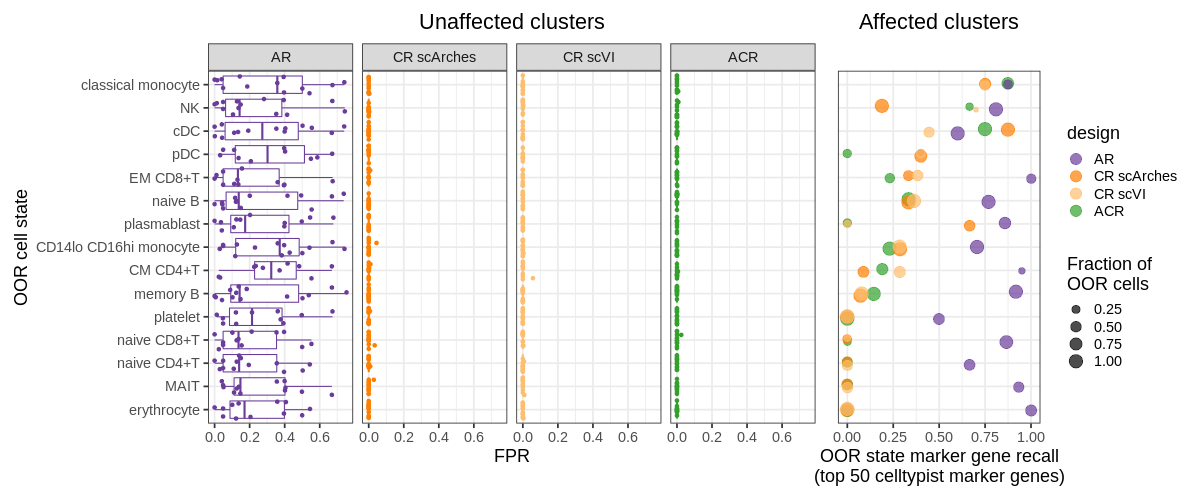

In [39]:
%%R -w 1200 -h 500 -i figdir
library(patchwork)
(pl1 + theme(legend.position='none', plot.title = element_text(hjust = 0.5)) | pl2 + remove_y_axis() + theme(plot.title = element_text(hjust = 0.5))) +
plot_layout(widths=c(3,1)) +
ggsave(paste0(figdir, "DE_comparison_metrics.png"), width=15, height=6) +
ggsave(paste0(figdir, "DE_comparison_metrics.pdf"), width=15, height=6)

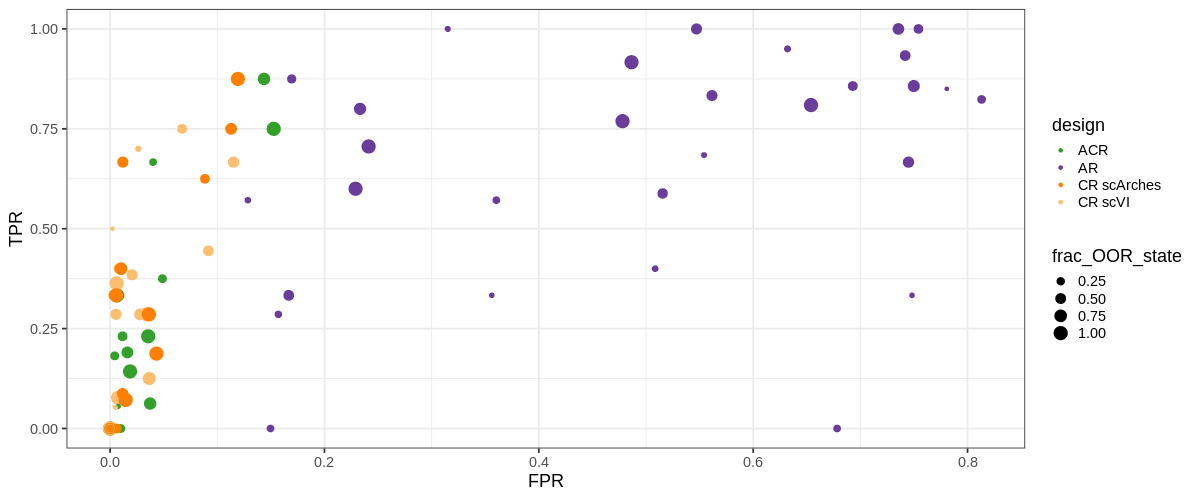

In [215]:
%%R -w 1200 -h 500
res_df_all %>%
filter(affected_anno) %>%
mutate(TPR=ifelse(is.na(TPR), 0, TPR)) %>%
group_by(OOR_state_simulation, design) %>%
mutate(frac_OOR_state = OOR_state/sum(OOR_state)) %>%
# slice_max(OOR_state, with_ties=FALSE) %>%
ungroup() %>%
group_by(OOR_state_simulation) %>%
mutate(mean_tpr= mean(TPR)) %>%
ungroup() %>%
arrange(mean_tpr) %>%
mutate(OOR_state_simulation = factor(OOR_state_simulation, levels=unique(OOR_state_simulation))) %>%
ggplot(aes(TPR, FPR, color=design)) +
geom_point(aes(size=frac_OOR_state), width=0.2) +
# geom_line(aes(group=OOR_state_simulation), color='grey') +
# facet_wrap(design~.) +
scale_color_manual(values=design_palette) +
theme_bw(base_size=18) +
coord_flip()

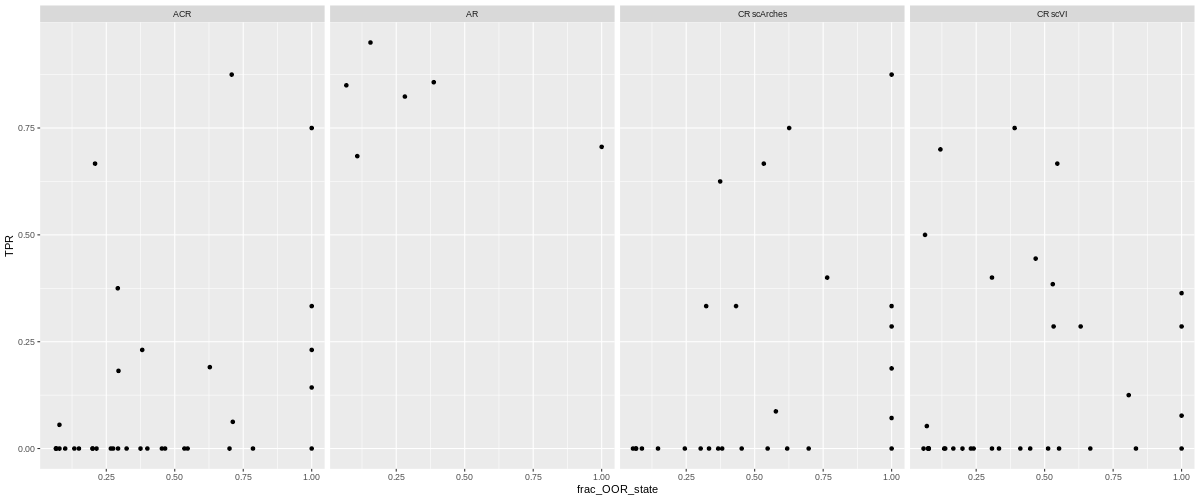

In [86]:
%%R -w 1200 -h 500
res_df_all %>%
filter(affected_anno) %>%
group_by(OOR_state_simulation, design) %>%
mutate(frac_OOR_state = OOR_state/sum(OOR_state)) %>%
ggplot(aes(frac_OOR_state, TPR)) +
# geom_boxplot(outlier.alpha=0) +
geom_point() +
facet_grid(.~design) 

/tmp/ipykernel_28311/3681882512.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
/tmp/ipykernel_28311/3681882512.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,2)
/tmp/ipykernel_28311/3681882512.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)
/tmp/ipykernel_28311/3681882512.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,2)
/tmp/ipykernel_28311/3681882512.py:21: MatplotlibDeprecationWarning: Aut

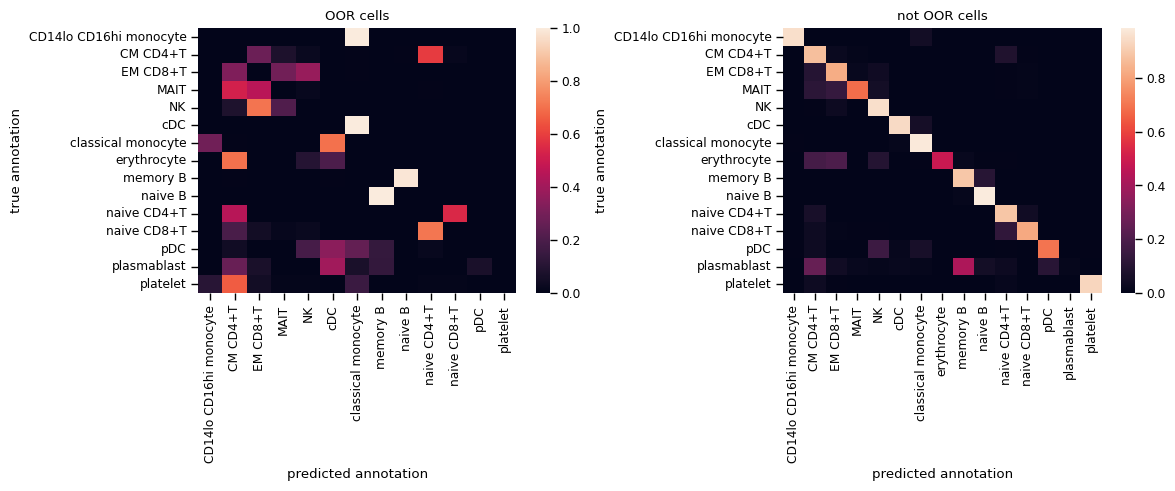

In [33]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
dirs = [x for x in os.listdir(outdir) if x.startswith('qPBMC_500cells_demo_perturb_cell_type') and x.endswith('_seed2022')]

sns.set_context('paper')


for design in ['AR.scArches','CR.scArches', 'CR.scVI', 'ACR.scArches']:
    plt.rcParams['figure.figsize'] = [12,5]
    pred_df_all = pd.DataFrame()
    for d in dirs:
        try:
            acr_pred = pd.read_csv(outdir + d + f'/DE_pred_annotations.{design}.csv')
        except:
            continue
        acr_pred = acr_pred[acr_pred['dataset_group'] == 'query']
        acr_pred['true annotation'] = [short_pop_names[x] for x in acr_pred['cell_annotation']]
        acr_pred['predicted annotation'] = [short_pop_names[x] for x in acr_pred['DE_cell_annotation']]
        acr_pred['simdir'] = d
        res_df = pd.concat([acr_pred])
        pred_df_all = pd.concat([pred_df_all, res_df])
    plt.subplot(1,2,1)
    sns.heatmap(sc.metrics.confusion_matrix('true annotation', 'predicted annotation', pred_df_all[pred_df_all['OOR_state'] == 1]));
    plt.title('OOR cells');
    plt.subplot(1,2,2)
    sns.heatmap(sc.metrics.confusion_matrix('true annotation', 'predicted annotation', pred_df_all[pred_df_all['OOR_state'] == 0]));
    plt.title('not OOR cells');
    plt.tight_layout();
    plt.savefig(figdir + f'conf_mat.{design}.pdf')

In [31]:
d

'qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022'

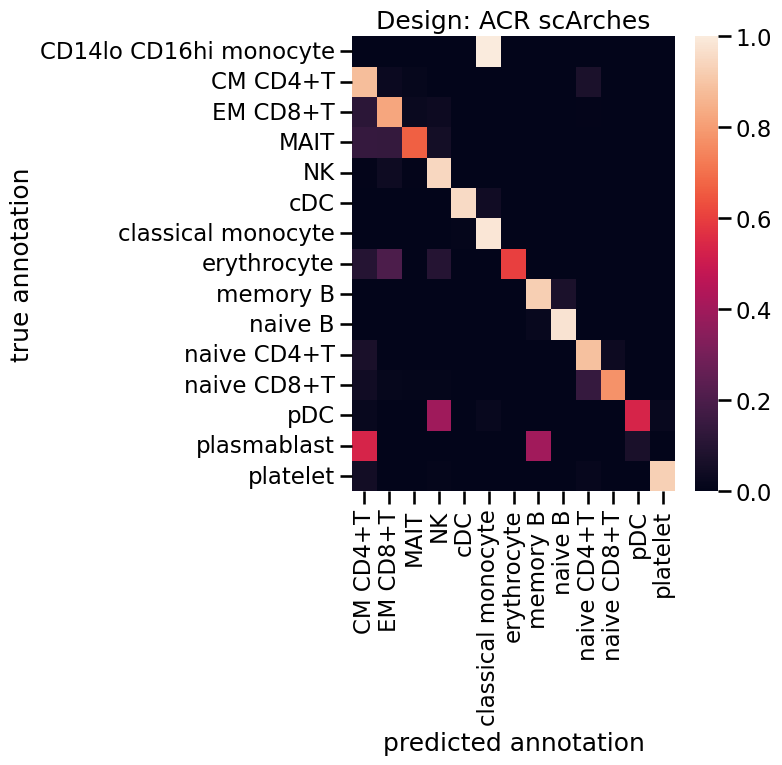

In [32]:
sns.set_context('talk');
plt.rcParams['figure.figsize'] = [8,8]
oor_state = 'CD14_low_CD16_positive_monocyte'
sns.heatmap(sc.metrics.confusion_matrix('true annotation', 'predicted annotation', acr_pred));
plt.title(f'Design: {design.replace(".", " ")}');
plt.tight_layout();
plt.savefig(figdir + f'conf_mat.example.pdf', bbox_inches='tight')

## Check DE comparison on AR design

In [107]:
import os
import scanpy as sc 
import pandas as pd
import numpy as np

## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

import celltypist

from pynndescent import NNDescent
from scipy.sparse import csc_matrix, identity
import pickle as pkl
from collections import Counter
import diff2atlas
from diff2atlas.utils import anndata2pseudobulk

def _train_weighted_knn(train_adata, outfile: str = None, use_rep: str = "X_scVI", n_neighbors: int = 50):
    """Trains a weighted KNN classifier on ``train_adata.obsm[use_rep]``.

    Parameters
    ----------
    train_adata: AnnData
        Annotated dataset to be used to train KNN classifier with ``label_key`` as the target variable.
    outfile: str
        path to pkl file to save trained model
    use_rep: str
        Name of the obsm layer to be used for calculation of neighbors. If set to "X", anndata.X will be
        used (default: X_scVI)
    n_neighbors: int
        Number of nearest neighbors in KNN classifier.
    """
    print(
        f"Weighted KNN with n_neighbors = {n_neighbors} ... ",
        end="",
    )
    if use_rep == "X":
        train_emb = train_adata.X
    elif use_rep in train_adata.obsm.keys():
        train_emb = train_adata.obsm[use_rep]
    else:
        raise ValueError("use_rep should be set to either 'X' or the name of the obsm layer to be used!")
    k_neighbors_transformer = NNDescent(
        train_emb,
        n_neighbors=n_neighbors,
        metric="euclidean",
        n_jobs=-1,
    )
    k_neighbors_transformer.prepare()

    if outfile is not None:
        with open(outfile, "wb") as f:
            pkl.dump(k_neighbors_transformer, f)
    return k_neighbors_transformer

def _pbulk_filter_genes(pbulk_sdata, min_samples = 10, min_counts = 20):
    '''Remove sporadically expressed genes'''
    n_samples = pbulk_sdata.X.copy()
    n_samples[pbulk_sdata.X.nonzero()] = 1
    pbulk_sdata.var['tot_samples'] =np.array(n_samples.sum(0)).ravel()
    pbulk_sdata.var['tot_counts'] = np.array(pbulk_sdata.X.sum(0)).ravel()
    return(pbulk_sdata[:,(pbulk_sdata.var['tot_counts'] > min_counts) & (pbulk_sdata.var['tot_samples'] > min_samples)])

def run_glmGamPoi_DE(pbulk_adata, 
                     design = '~ nhood_groups',
                    ref_level = 'in_nhoods_other',
                    contrast = 'nhood_groupsin_nhoods_critical',
                     n_hvgs = 5000):
    '''
    Run R code for DE analysis with glmGamPoi
    
    Params:
    ------
    - pbulk_adata: anndata object with pseudobulked data
    
    '''
    
    ## Define R function
    glmgampoi_str = f'''
        library(SingleCellExperiment)
        library(glmGamPoi)
        library(scran)
        library(scater)

        run_de <- function(args){{
            pbulk_sdata_X <- args[[1]]
            pbulk_sdata_obs <- args[[2]]
            pbulk_sdata_var <- args[[3]]
            n_hvgs <- args[[4]]

            sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)
            sce <- logNormCounts(sce)

            ## Feature selection w scran (just on test cell types)
            dec <- modelGeneVar(sce)
            hvgs <- getTopHVGs(dec, n = n_hvgs)
            subset_sce <- sce[hvgs,]

            ## Fit
            fit <- glm_gp(subset_sce, design = {design}, reference_level = '{ref_level}')

            ## Test 
            de_res <- test_de(fit, contrast = '{contrast}')    
            de_res[,'gene_name'] <- pbulk_sdata_var[hvgs,]['gene_name']
            return(de_res)
        }}'''
    print(glmgampoi_str)
    
    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP
    
    ## Get anndata components
    pbulk_sdata_X = pbulk_adata.X.toarray().copy()
    pbulk_sdata_obs = pbulk_adata.obs.copy()
    pbulk_sdata_var = pbulk_adata.var.copy()
    
    r_pkg = STAP(glmgampoi_str, "r_pkg")
    # this was needed for the code to run on jhub
    # if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    args = [pbulk_sdata_X, pbulk_sdata_obs, pbulk_sdata_var, n_hvgs]
    de_res_df = r_pkg.run_de(args).to_csvfile('./DE_results.csv')
    de_res_df = pd.read_csv('./DE_results.csv', index_col=0)
    de_res_df.index = de_res_df['gene_name']
    de_res_df.drop('name', 1, inplace=True)
    os.remove('./DE_results.csv')
    return(de_res_df)

## Make pseudobulk adata for cells if different nhood groups and samples
def run_annotation_DE(acr_adata, ct, diff_reference, sample_col='sample_id', n_hvgs=10000, annotation_col='cell_annotation'):
    pbulk_use_layer = None
    sdata = acr_adata[acr_adata.obs[f'DE_{annotation_col}'] == ct].to_memory()
    # sdata.X = sdata.layers['counts'].copy()
    # if confounders_obs is None:
    design = '~dataset_group'
    pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[sample_col, 'dataset_group'], 
            min_ncells=1, 
            use_layer=pbulk_use_layer)

    pbulk_sdata = _pbulk_filter_genes(pbulk_sdata).copy()
    if pbulk_sdata.n_vars < 1:
        print(f"Skipping {ct} - no gene passes criteria")
        raise ValueError()
    de_results = run_glmGamPoi_DE(pbulk_sdata, 
                                  design=design, ref_level=diff_reference, 
                                  contrast =f'dataset_groupquery',
                                  n_hvgs = n_hvgs)
    return(de_results)

In [99]:
design = '~ nhood_groups'
ref_level = 'in_nhoods_other'
contrast = 'nhood_groupsin_nhoods_critical'

In [100]:
glmgampoi_str = f'''
        library(SingleCellExperiment)
        library(glmGamPoi)
        library(scran)
        library(scater)

        run_de <- function(args){{
            pbulk_sdata_X <- args[[1]]
            pbulk_sdata_obs <- args[[2]]
            pbulk_sdata_var <- args[[3]]
            n_hvgs <- args[[4]]

            sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)
            sce <- logNormCounts(sce)

            ## Feature selection w scran (just on test cell types)
            dec <- modelGeneVar(sce)
            hvgs <- getTopHVGs(dec, n = n_hvgs)
            subset_sce <- sce[hvgs,]

            ## Fit
            fit <- glm_gp(subset_sce, design = {design}, reference_level = '{ref_level}')

            ## Test 
            de_res <- test_de(fit, contrast = '{contrast}')    
            de_res[,'gene_name'] <- pbulk_sdata_var[hvgs,]['gene_name']
            return(de_res)
        }}'''
    
#     import rpy2.robjects.pandas2ri
#     import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import STAP
    



In [102]:

r_pkg = STAP(glmgampoi_str, "r_pkg")

In [45]:
simdir='/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp//qPBMC_500cells_demo_perturb_cell_typeCD14_low_CD16_positive_monocyte_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/'

In [50]:
classifier_reference = {
    'CR':'ctrl',
    'ACR':'ctrl',
    'AR':'atlas'
}

diff_reference = {
    'CR':'ctrl',
    'ACR':'ctrl',
    'AR':'atlas'
}

# load
print('Loading')
pbulk_adata = sc.read_h5ad(simdir + f'/pseudobulk_DE.{design}.{emb_method}.h5ad', backed=False)

Loading


In [48]:
design='CR'
emb_method='scArches'
annotation_col = 'cell_annotation'

In [65]:
acr_adata = sc.read_h5ad(simdir + f'{design}_design.{emb_method}_milo.h5ad', backed=True)

acr_adata.obs['OOR_state'] = acr_adata.obs[annotation_col] == ct_oi
n_oor_cells = acr_adata.obs['OOR_state'].sum()
anno_df = acr_adata.obs[['OOR_state', f'DE_{annotation_col}']].groupby(f'DE_{annotation_col}').sum('OOR_state')

In [106]:
pbulk_sdata

AnnData object with n_obs × n_vars = 24 × 8825
    obs: 'sample_id', 'dataset_group', 'Site', 'DE_cell_annotation', 'n_cells'
    var: 'gene_id', 'gene_name', 'tot_samples', 'tot_counts'

In [109]:
pbulk_sdata = _pbulk_filter_genes(pbulk_sdata).copy()
if pbulk_sdata.n_vars < 1:
    print(f"Skipping {ct} - no gene passes criteria")
    raise ValueError()
de_results = run_glmGamPoi_DE(pbulk_sdata, 
                            design=design, ref_level=diff_reference[design], 
                            contrast =f'dataset_groupquery',
                            n_hvgs = 10000)

KeyError: '~ nhood_groups'

In [68]:
acr_adata = acr_adata.to_memory()

In [52]:
pbulk_adata = sc.read_h5ad(simdir + f'pseudobulk_DE.{design}.{emb_method}.h5ad')

In [67]:
ct_oi = simdir.split("cell_type")[-1].split("_queryBatch")[0]
pbulk_adata[pbulk_adata.obs['DE_cell_annotation'] == ct_oi]

View of AnnData object with n_obs × n_vars = 0 × 11724
    obs: 'sample_id', 'dataset_group', 'Site', 'DE_cell_annotation', 'n_cells'
    var: 'gene_id', 'gene_name'

In [74]:
de_ct = 'classical_monocyte'
pbulk_sdata = pbulk_adata[pbulk_adata.obs[f'DE_{annotation_col}'] == de_ct].copy()

In [83]:
pbulk_sdata

AnnData object with n_obs × n_vars = 24 × 11724
    obs: 'sample_id', 'dataset_group', 'Site', 'DE_cell_annotation', 'n_cells'
    var: 'gene_id', 'gene_name'

In [82]:
de_results = run_annotation_DE(acr_adata, de_ct, 
                                diff_reference = 'ctrl' ,
                                    sample_col='sample_id',
                                      annotation_col = annotation_col)

KeyError: 'DE_cell_annotation'

In [39]:
ct_markers_df = pd.DataFrame(index=pbulk_adata.var['gene_name'], columns = celltypist_anno_dict.keys())
for ct in ct_markers_df.columns:
    ct_markers = ct_model.extract_top_markers(celltypist_anno_dict[ct], top_n=50)
    ct_markers_df[ct] = ct_markers_df.index.isin(ct_markers)
print('Testing')
ct_oi = simdir.split("cell_type")[-1].split("_queryBatch")[0]

## Find affected annotation (where are the OOR cells?)
acr_adata.obs['OOR_state'] = acr_adata.obs[annotation_col] == ct_oi
n_oor_cells = acr_adata.obs['OOR_state'].sum()
anno_df = acr_adata.obs[['OOR_state', f'DE_{annotation_col}']].groupby(f'DE_{annotation_col}').sum('OOR_state')
anno_df['affected_anno'] = anno_df['OOR_state'] > (n_oor_cells*0.5)

anno_df['FPR'] = np.nan
anno_df['TPR'] = np.nan

# de_ct = 'classical_monocyte'
for de_ct in anno_df.index:
    try:
#             print(de_ct)
        de_results = run_annotation_DE(acr_adata, de_ct, 
                                       diff_reference = diff_reference[design], 
                                       sample_col='sample_id',
                                      annotation_col =annotation_col)
    except:
        print(f"Skipping {de_ct} - no gene passes criteria")
        continue

    de_results[f'DE_{annotation_col}'] = de_ct

    if anno_df.loc[de_ct]['affected_anno']:
        de_results['is_OORstate_marker'] = de_results['gene_name'].isin(ct_markers_df.index[ct_markers_df[ct_oi]].tolist())
        TP = sum(de_results[de_results['is_OORstate_marker']].adj_pval < 0.1)
        FN = sum(de_results[de_results['is_OORstate_marker']].adj_pval >= 0.1)
        TN = sum(de_results[~de_results['is_OORstate_marker']].adj_pval >= 0.1)
        FP = sum(de_results[~de_results['is_OORstate_marker']].adj_pval < 0.1)
        anno_df.loc[de_ct, 'TPR'] = TP / (TP+FN)
    else:
        FP = sum(de_results['adj_pval'] < 0.1)
        TN = sum(de_results['adj_pval'] >= 0.1)
        TP = 0
        FN = 0

    anno_df.loc[de_ct, 'FPR'] = FP / (FP+TN)

anno_df['design'] = design 
anno_df['OOR_state_simulation'] = ct_oi

Training
Predicting


In [40]:
pred_annotations

,DE_cell_annotation,dataset_group,cell_annotation
10_1126_science_abc6261-Arunachalam-cov07_TTGATGGAGCTGACTT-1,effector_memory_CD8_positive_alpha_beta_T_cell,atlas,effector_memory_CD8_positive_alpha_beta_T_cell
powell_eqtl-TGCGCAGCAGCTGGCT-48,platelet,atlas,platelet
powell_eqtl-CGAATGTTCTAGCACA-48,central_memory_CD4_positive_alpha_beta_T_cell,atlas,central_memory_CD4_positive_alpha_beta_T_cell
powell_eqtl-GTCATTTGTTTCGCTC-48,central_memory_CD4_positive_alpha_beta_T_cell,atlas,central_memory_CD4_positive_alpha_beta_T_cell
powell_eqtl-CTGAAACGTCAAAGCG-48,central_memory_CD4_positive_alpha_beta_T_cell,atlas,central_memory_CD4_positive_alpha_beta_T_cell
...,...,...,...
10_1038_s41591_021_01329_2-AAACCTGAGTCTTGCA-MH8919278,effector_memory_CD8_positive_alpha_beta_T_cell,query,effector_memory_CD8_positive_alpha_beta_T_cell
10_1038_s41591_021_01329_2-TAGGCATGTCTGATCA-MH8919278,memory_B_cell,query,memory_B_cell
10_1038_s41591_021_01329_2-CTGCTGTAGATATGCA-MH8919278,naive_B_cell,query,naive_B_cell
10_1038_s41591_021_01329_2-GTCCTCACAGACAGGT-MH8919278,effector_memory_CD8_positive_alpha_beta_T_cell,query,effector_memory_CD8_positive_alpha_beta_T_cell


<AxesSubplot: xlabel='DE_cell_annotation', ylabel='cell_annotation'>

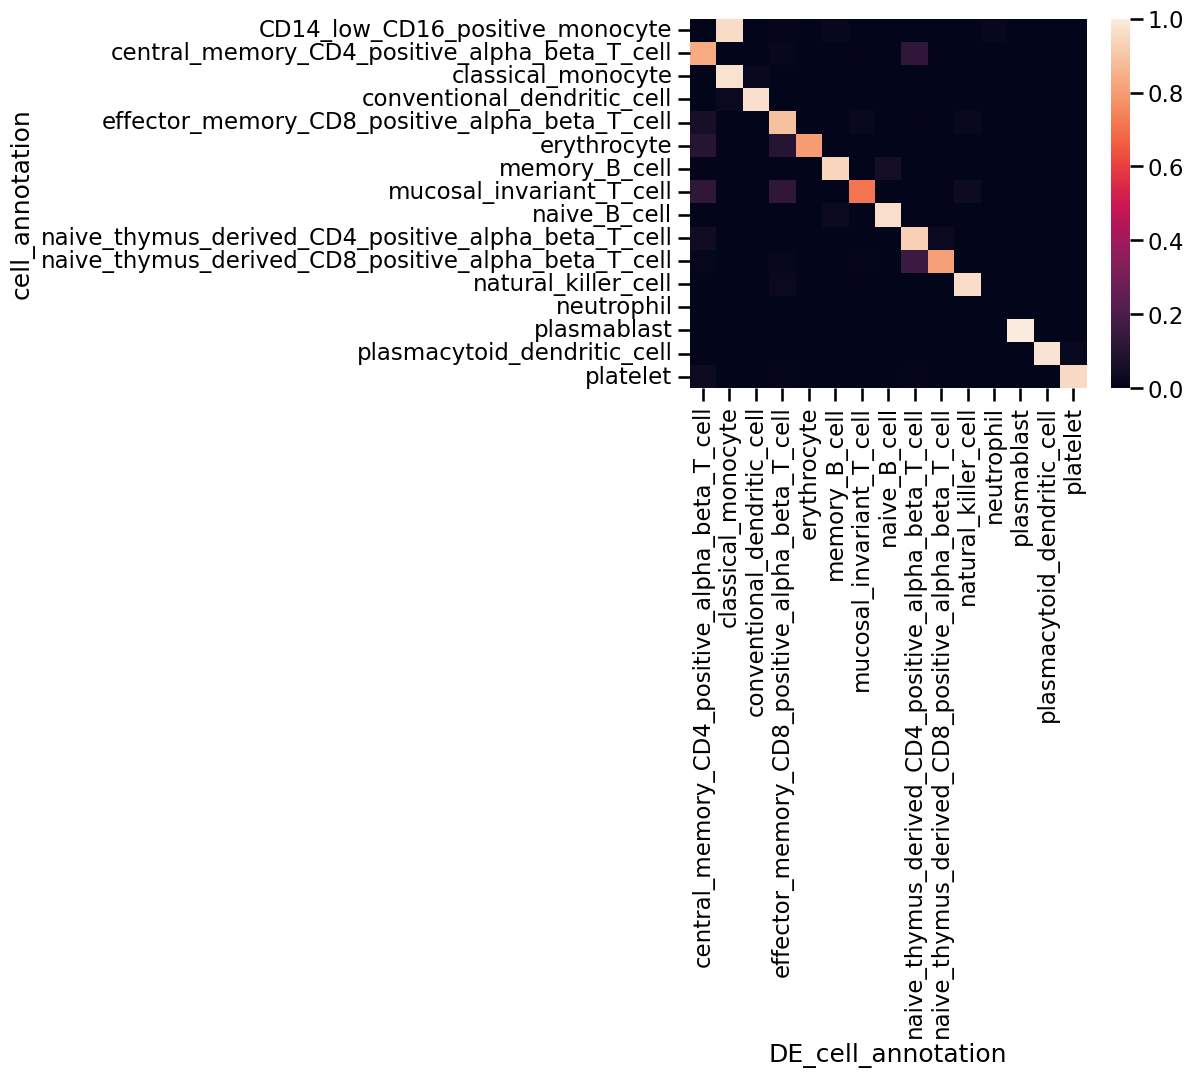

In [42]:
sns.heatmap(sc.metrics.confusion_matrix('cell_annotation', 'DE_cell_annotation', pred_annotations[pred_annotations.dataset_group=='query']), xticklabels=True, yticklabels=True)

In [46]:
print('Testing')
ct_oi = simdir.split("cell_type")[-1].split("_queryBatch")[0]

## Find affected annotation (where are the OOR cells?)
acr_adata.obs['OOR_state'] = acr_adata.obs[annotation_col] == ct_oi
n_oor_cells = acr_adata.obs['OOR_state'].sum()
anno_df = acr_adata.obs[['OOR_state', f'DE_{annotation_col}']].groupby(f'DE_{annotation_col}').sum('OOR_state')
anno_df['affected_anno'] = anno_df['OOR_state'] > (n_oor_cells*0.5)

anno_df['FPR'] = np.nan
anno_df['TPR'] = np.nan

# de_ct = 'classical_monocyte'
for de_ct in anno_df.index:
#     try:
#             print(de_ct)
    de_results = run_annotation_DE(acr_adata, de_ct, 
                                       diff_reference = diff_reference[design], 
                                       sample_col='sample_id',
                                      annotation_col =annotation_col)
#     except:
#         print(f"Skipping {de_ct} - no gene passes criteria")
#         continue

    de_results[f'DE_{annotation_col}'] = de_ct

    if anno_df.loc[de_ct]['affected_anno']:
        de_results['is_OORstate_marker'] = de_results['gene_name'].isin(ct_markers_df.index[ct_markers_df[ct_oi]].tolist())
        TP = sum(de_results[de_results['is_OORstate_marker']].adj_pval < 0.1)
        FN = sum(de_results[de_results['is_OORstate_marker']].adj_pval >= 0.1)
        TN = sum(de_results[~de_results['is_OORstate_marker']].adj_pval >= 0.1)
        FP = sum(de_results[~de_results['is_OORstate_marker']].adj_pval < 0.1)
        anno_df.loc[de_ct, 'TPR'] = TP / (TP+FN)
    else:
        FP = sum(de_results['adj_pval'] < 0.1)
        TN = sum(de_results['adj_pval'] >= 0.1)
        TP = 0
        FN = 0

    anno_df.loc[de_ct, 'FPR'] = FP / (FP+TN)

anno_df['design'] = design 
anno_df['OOR_state_simulation'] = ct_oi

Testing


---

---

# Old

## Get marker genes from celltypist

In [12]:
import celltypist

In [32]:
# Match cell types 
celltypist_anno_dict = {
'natural_killer_cell':'NK cells',
 'memory_B_cell':'Memory B cells',
 'central_memory_CD4_positive_alpha_beta_T_cell':'Tem/Effector helper T cells',
 'naive_thymus_derived_CD4_positive_alpha_beta_T_cell':'Tcm/Naive helper T cells',
 'naive_thymus_derived_CD8_positive_alpha_beta_T_cell':'Tcm/Naive cytotoxic T cells',
 'naive_B_cell':'Naive B cells',
 'classical_monocyte':'Classical monocytes',
 'conventional_dendritic_cell':'DC',
 'effector_memory_CD8_positive_alpha_beta_T_cell':'Tem/Effector cytotoxic T cells',
 'mucosal_invariant_T_cell':'MAIT cells',
 'plasmacytoid_dendritic_cell':'pDC',
 'platelet':'Megakaryocytes/platelets',
 'plasmablast':'Plasma cells',
 'erythrocyte':'Erythrocytes',
 'CD14_low_CD16_positive_monocyte':'Non-classical monocytes'
}

In [34]:
# Get celltypist model for immune cells
ct_model = celltypist.Model.load('Immune_All_Low.pkl')

In [17]:
for ct in celltypist_anno_dict.keys():
    ct_model.extract_top_markers(celltypist_anno_dict[ct], top_n=50)

In [15]:
from pynndescent import NNDescent
from scipy.sparse import csc_matrix, identity
import pickle as pkl
from collections import Counter
import diff2atlas
from diff2atlas.utils import anndata2pseudobulk

def _train_weighted_knn(train_adata, outfile: str = None, use_rep: str = "X_scVI", n_neighbors: int = 50):
    """Trains a weighted KNN classifier on ``train_adata.obsm[use_rep]``.

    Parameters
    ----------
    train_adata: AnnData
        Annotated dataset to be used to train KNN classifier with ``label_key`` as the target variable.
    outfile: str
        path to pkl file to save trained model
    use_rep: str
        Name of the obsm layer to be used for calculation of neighbors. If set to "X", anndata.X will be
        used (default: X_scVI)
    n_neighbors: int
        Number of nearest neighbors in KNN classifier.
    """
    print(
        f"Weighted KNN with n_neighbors = {n_neighbors} ... ",
        end="",
    )
    if use_rep == "X":
        train_emb = train_adata.X
    elif use_rep in train_adata.obsm.keys():
        train_emb = train_adata.obsm[use_rep]
    else:
        raise ValueError("use_rep should be set to either 'X' or the name of the obsm layer to be used!")
    k_neighbors_transformer = NNDescent(
        train_emb,
        n_neighbors=n_neighbors,
        metric="euclidean",
        n_jobs=-1,
    )
    k_neighbors_transformer.prepare()

    if outfile is not None:
        with open(outfile, "wb") as f:
            pkl.dump(k_neighbors_transformer, f)
    return k_neighbors_transformer

def _pbulk_filter_genes(pbulk_sdata, min_samples = 10, min_counts = 20):
    '''Remove sporadically expressed genes'''
    n_samples = pbulk_sdata.X.copy()
    n_samples[pbulk_sdata.X.nonzero()] = 1
    pbulk_sdata.var['tot_samples'] =np.array(n_samples.sum(0)).ravel()
    pbulk_sdata.var['tot_counts'] = np.array(pbulk_sdata.X.sum(0)).ravel()
    return(pbulk_sdata[:,(pbulk_sdata.var['tot_counts'] > min_counts) & (pbulk_sdata.var['tot_samples'] > min_samples)])

def run_glmGamPoi_DE(pbulk_adata, 
                     design = '~ Site + nhood_groups',
                    ref_level = 'in_nhoods_other',
                    contrast = 'nhood_groupsin_nhoods_critical',
                     n_hvgs = 5000):
    '''
    Run R code for DE analysis with glmGamPoi
    
    Params:
    ------
    - pbulk_adata: anndata object with pseudobulked data
    
    '''
    
    ## Define R function
    glmgampoi_str = f'''
        library(SingleCellExperiment)
        library(glmGamPoi)
        library(scran)
        library(scater)

        run_de <- function(args){{
            pbulk_sdata_X <- args[[1]]
            pbulk_sdata_obs <- args[[2]]
            pbulk_sdata_var <- args[[3]]
            n_hvgs <- args[[4]]

            sce <- SingleCellExperiment(assays = list(counts = t(pbulk_sdata_X)), colData = pbulk_sdata_obs)
            sce <- logNormCounts(sce)

            ## Feature selection w scran (just on test cell types)
            dec <- modelGeneVar(sce)
            hvgs <- getTopHVGs(dec, n = n_hvgs)
            subset_sce <- sce[hvgs,]

            ## Fit
            fit <- glm_gp(subset_sce, design = {design}, reference_level = '{ref_level}')

            ## Test 
            de_res <- test_de(fit, contrast = '{contrast}')    
            de_res[,'gene_name'] <- pbulk_sdata_var[hvgs,]['gene_name']
            return(de_res)
        }}'''
    
    import rpy2.robjects.pandas2ri
    import rpy2.robjects.numpy2ri
    from rpy2.robjects.packages import STAP
    
    ## Get anndata components
    pbulk_sdata_X = pbulk_adata.X.toarray().copy()
    pbulk_sdata_obs = pbulk_adata.obs.copy()
    pbulk_sdata_var = pbulk_adata.var.copy()
    
    r_pkg = STAP(glmgampoi_str, "r_pkg")
    # this was needed for the code to run on jhub
    # if you have a different version of rpy2 you may not need these two lines
    rpy2.robjects.pandas2ri.activate()
    rpy2.robjects.numpy2ri.activate()
    
    # PASS OBJECTS INTO FUNCTION
    args = [pbulk_sdata_X, pbulk_sdata_obs, pbulk_sdata_var, n_hvgs]
    de_res_df = r_pkg.run_de(args).to_csvfile('./DE_results.csv')
    de_res_df = pd.read_csv('./DE_results.csv', index_col=0)
    de_res_df.index = de_res_df['gene_name']
    de_res_df.drop('name', 1, inplace=True)
    os.remove('./DE_results.csv')
    return(de_res_df)


Created a temporary directory at /tmp/tmp0igbly35
Writing /tmp/tmp0igbly35/_remote_module_non_scriptable.py
Global seed set to 0
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [16]:
## Make pseudobulk adata for cells if different nhood groups and samples
def run_annotation_DE(acr_adata, ct, diff_reference, sample_col='sample_id', n_hvgs=10000, annotation_col='cell_annotation'):
    pbulk_use_layer = None
    sdata = acr_adata[acr_adata.obs[f'DE_{annotation_col}'] == ct].to_memory()
    # sdata.X = sdata.layers['counts'].copy()
    # if confounders_obs is None:
    design = '~dataset_group'
    pbulk_sdata = diff2atlas.utils.anndata2pseudobulk(
            sdata, 
            group_by=[sample_col, 'dataset_group', 'Site'], 
            min_ncells=1, 
            use_layer=pbulk_use_layer)

    pbulk_sdata = _pbulk_filter_genes(pbulk_sdata).copy()
    if pbulk_sdata.n_vars < 1:
        print(f"Skipping {ct} - no gene passes criteria")
        raise ValueError()
    de_results = run_glmGamPoi_DE(pbulk_sdata, 
                                  design=design, ref_level=diff_reference, 
                                  contrast =f'dataset_groupquery',
                                  n_hvgs = n_hvgs)
    return(de_results)

## Load data

In [18]:
# annotation_col = 'cell_annotation'
# sample_col = 'sample_id'
# diff_reference = 'ctrl'
# design = 'CR'

def run_DE_benchmark(d, design, 
                     ct_model,
                     annotation_col = 'cell_annotation',
                     sample_col = 'sample_id',
                     outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
                    ):
    '''
    Run DE benchmark
    '''
    classifier_reference = {
        'CR':'ctrl',
        'ACR':'atlas',
        'AR':'atlas'
    }
    
    diff_reference = {
        'CR':'ctrl',
        'ACR':'ctrl',
        'AR':'atlas'
    }
    
    # load
    print('Loading')
    acr_adata = sc.read_h5ad(outdir + d + f'/{design.lower()}_design.h5ad', backed=True)
    
    # Store top markers for each celltype (from celltypist model)
    ct_markers_df = pd.DataFrame(index=acr_adata.var['gene_name'], columns = celltypist_anno_dict.keys())
    for ct in ct_markers_df.columns:
        ct_markers = ct_model.extract_top_markers(celltypist_anno_dict[ct], top_n=50)
        ct_markers_df[ct] = ct_markers_df.index.isin(ct_markers)
        
    print('Training')
    ## Train classifier from latent embedding
    try:
        with open(outdir + d + f"/weighted_KNN_classifier.{classifier_reference[design]}.pkl", "rb") as f:
            knn_classifier = pkl.load(f)
    except:
        knn_classifier = _train_weighted_knn(
            acr_adata[acr_adata.obs['dataset_group'] == classifier_reference[design]],
            use_rep = 'X_scVI',
            outfile=outdir + d + f"/weighted_KNN_classifier.{classifier_reference[design]}.pkl",
            n_neighbors = 50
        )
    
    print('Predicting')
    y_train_labels = acr_adata[acr_adata.obs['dataset_group'] == classifier_reference[design]].obs[annotation_col]
    query_adata = acr_adata[acr_adata.obs['dataset_group'] != classifier_reference[design]]

    # Predict neighbors
    query_emb = query_adata.obsm['X_scVI'].toarray()
    top_k_indices, top_k_distances = knn_classifier.query(query_emb, k=knn_classifier.n_neighbors)

    stds = np.std(top_k_distances, axis=1)
    stds = (2.0 / stds) ** 2
    stds = stds.reshape(-1, 1)

    top_k_distances_tilda = np.exp(-np.true_divide(top_k_distances, stds))

    # Compute probs and labels
    weights = top_k_distances_tilda / np.sum(top_k_distances_tilda, axis=1, keepdims=True)
    uncertainties = pd.DataFrame(columns=["pred_uncertainty"], index=query_adata.obs_names)
    pred_labels = pd.DataFrame(columns=["pred_label"], index=query_adata.obs_names)

    for i in range(len(weights)):
        counter = Counter(y_train_labels[top_k_indices[i]])
        # Here I assume the highest no of neighbors also has the highest probability
        best_label = max(counter, key=counter.get)
        best_prob = weights[i, y_train_labels[top_k_indices[i]] == best_label].sum()

        uncertainties.iloc[i] = max(1 - best_prob, 0)
        pred_labels.iloc[i] = best_label

    # Save predicted labels for DE analysis
    acr_adata.obs[f'DE_{annotation_col}'] = acr_adata.obs[annotation_col].copy()
    acr_adata.obs.loc[pred_labels.index, f'DE_{annotation_col}'] = pred_labels.values 
    acr_adata.obs[f'DE_{annotation_col}'] = acr_adata.obs[f'DE_{annotation_col}'].cat.remove_unused_categories()

    # sns.heatmap(
    #     sc.metrics.confusion_matrix(annotation_col, f'DE_{annotation_col}', 
    #                                 acr_adata.obs[acr_adata.obs['dataset_group'] == 'query']))
    
    print('Testing')
    ct_oi = d.split("cell_type")[-1].split("_queryBatch")[0]

    ## Find affected annotation (where are the OOR cells?)
    acr_adata.obs['OOR_state'] = acr_adata.obs[annotation_col] == ct_oi
    n_oor_cells = acr_adata.obs['OOR_state'].sum()
    anno_df = acr_adata.obs[['OOR_state', f'DE_{annotation_col}']].groupby(f'DE_{annotation_col}').sum('OOR_state')
    anno_df['affected_anno'] = anno_df['OOR_state'] > (n_oor_cells*0.5)

    anno_df['FPR'] = np.nan
    anno_df['TPR'] = np.nan

    # de_ct = 'classical_monocyte'
    for de_ct in anno_df.index:
        try:
#             print(de_ct)
            de_results = run_annotation_DE(acr_adata, de_ct, 
                                           diff_reference = diff_reference[design], 
                                           sample_col='sample_id',
                                          annotation_col =annotation_col)
        except:
            print(f"Skipping {de_ct} - no gene passes criteria")
            continue
            
        de_results[f'DE_{annotation_col}'] = de_ct

        if anno_df.loc[de_ct]['affected_anno']:
            de_results['is_OORstate_marker'] = de_results['gene_name'].isin(ct_markers_df.index[ct_markers_df[ct_oi]].tolist())
            TP = sum(de_results[de_results['is_OORstate_marker']].adj_pval < 0.1)
            FN = sum(de_results[de_results['is_OORstate_marker']].adj_pval >= 0.1)
            TN = sum(de_results[~de_results['is_OORstate_marker']].adj_pval >= 0.1)
            FP = sum(de_results[~de_results['is_OORstate_marker']].adj_pval < 0.1)
            anno_df.loc[de_ct, 'TPR'] = TP / (TP+FN)
        else:
            FP = sum(de_results['adj_pval'] < 0.1)
            TN = sum(de_results['adj_pval'] >= 0.1)
            TP = 0
            FN = 0

        anno_df.loc[de_ct, 'FPR'] = FP / (FP+TN)

    anno_df['design'] = design 
    anno_df['OOR_state_simulation'] = ct_oi
    return(anno_df)

In [19]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
dirs = [x for x in os.listdir(outdir) if x.startswith('qPBMC_500cells_demo_perturb_cell_') and not x.endswith("withOOR") and not x.endswith(".pkl")]

In [24]:
cr_results

,OOR_state,affected_anno,FPR,TPR,design,OOR_state_simulation
DE_cell_annotation,,,,,,
CD14_low_CD16_positive_monocyte,0,False,0.000000,NaN,CR,memory_B_cell
central_memory_CD4_positive_alpha_beta_T_cell,0,False,0.000000,NaN,CR,memory_B_cell
classical_monocyte,0,False,0.000000,NaN,CR,memory_B_cell
conventional_dendritic_cell,0,False,0.000240,NaN,CR,memory_B_cell
effector_memory_CD8_positive_alpha_beta_T_cell,0,False,0.000000,NaN,CR,memory_B_cell
erythrocyte,0,False,NaN,NaN,CR,memory_B_cell
mucosal_invariant_T_cell,0,False,0.000000,NaN,CR,memory_B_cell
naive_B_cell,397,True,0.014611,0.071429,CR,memory_B_cell
naive_thymus_derived_CD4_positive_alpha_beta_T_cell,1,False,0.000000,NaN,CR,memory_B_cell


In [20]:
df = pd.DataFrame()
for d in dirs:
    cr_results = run_DE_benchmark(d, design='CR', ct_model=ct_model)
    acr_results = run_DE_benchmark(d, design='ACR', ct_model=ct_model)
    d_df = pd.concat([acr_results.reset_index(), cr_results.reset_index()])    
    if d_df.shape[0] > 0:
        df = pd.concat([df, d_df])

Loading
Training
Weighted KNN with n_neighbors = 50 ... Predicting
Testing
Skipping erythrocyte - no gene passes criteria
Skipping erythrocyte - no gene passes criteria
Skipping plasmablast - no gene passes criteria
Skipping plasmablast - no gene passes criteria
Loading
Training
Predicting


IndexError: positional indexers are out-of-bounds

In [176]:
%%R -i df
head(df)

                              DE_cell_annotation OOR_state affected_anno
1                CD14_low_CD16_positive_monocyte         0         FALSE
2  central_memory_CD4_positive_alpha_beta_T_cell         2         FALSE
3                             classical_monocyte         0         FALSE
4                    conventional_dendritic_cell         3         FALSE
5 effector_memory_CD8_positive_alpha_beta_T_cell         0         FALSE
6                                    erythrocyte         0         FALSE
          FPR TPR design OOR_state_simulation
1 0.000000000 NaN    ACR        memory_B_cell
2 0.000000000 NaN    ACR        memory_B_cell
3 0.000000000 NaN    ACR        memory_B_cell
4 0.000262605 NaN    ACR        memory_B_cell
5 0.000000000 NaN    ACR        memory_B_cell
6         NaN NaN    ACR        memory_B_cell


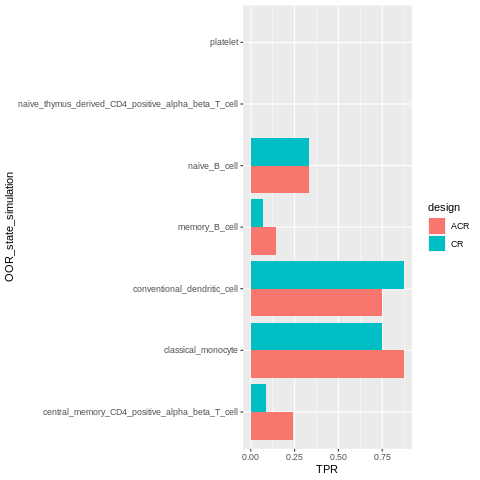

In [198]:
%%R
df %>%
filter(affected_anno == TRUE) %>%
group_by(OOR_state_simulation) %>%
mutate(n_rows=n()) %>%
ungroup() %>%
filter(n_rows > 1) %>%
ggplot(aes(OOR_state_simulation, TPR, fill=design)) +
geom_col(position='dodge') +
coord_flip()

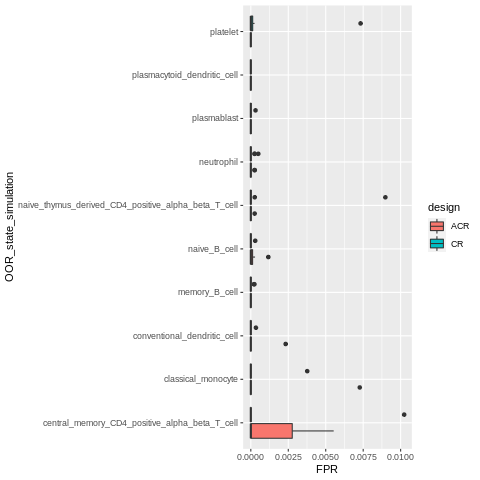

In [204]:
%%R
df %>%
filter(affected_anno == FALSE & OOR_state == 0) %>%
# head()

ggplot(aes(OOR_state_simulation, FPR, fill=design)) +
geom_boxplot() +
coord_flip()

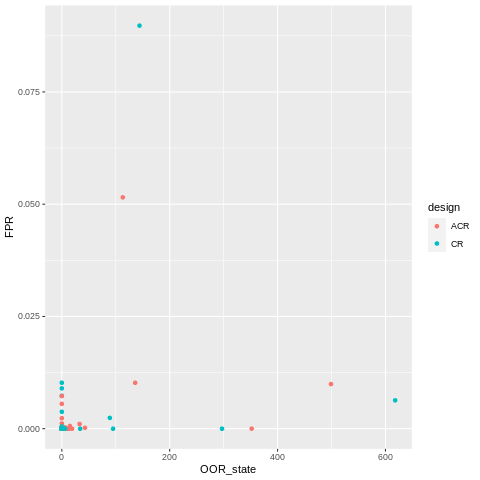

In [202]:
%%R
df %>%
filter(affected_anno == FALSE) %>%
# head()

ggplot(aes(OOR_state, FPR, color=design)) +
geom_point()

---

In [131]:
design = 'CR'

In [173]:
d_df = pd.concat([acr_results, cr_results])